In [7]:
!pip install keras-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 854 kB/s 
     |████████████████████████████████| 965 kB 11.1 MB/s 
     |████████████████████████████████| 9.5 MB 47.1 MB/s 
     |████████████████████████████████| 619 kB 63.8 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=23c3ea85d308b50fb84c3b79b066ed72aa78b5cfd6b5ccf68ad66baa88f82448
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import keras_ocr
import math

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def resize_image(img, size=(28,28)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

In [11]:
def kmeans(img):
  img = resize_image(img, size=(int(img.shape[0]/4),int(img.shape[1]/4)))


  # converting to LAB color space
  lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  # feel free to try different values for the limit and grid size:
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))

  # Converting image from LAB Color model to BGR color spcae
  enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  # Stacking the original image with the enhanced image
  result = np.hstack((img, enhanced_img))

  Z = result.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  K = 3

  attemps = 10
  #ret,label,centers=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  _,labels,(centers)=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  centers = np.uint8(centers)
  res = centers[labels.flatten()]
  res2 = res.reshape((result.shape))

  return res2

In [12]:


def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def inpaint_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 12s 4s/step


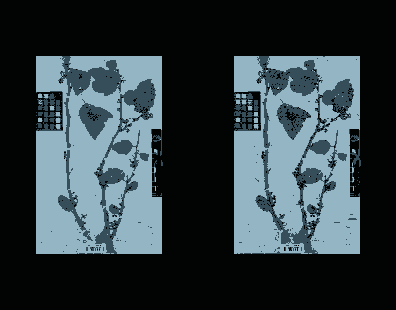

In [16]:
image = cv2.imread('/content/drive/MyDrive/Projet/Train/amborella/amborella098.jpg')


image = resize_image(image, size=(int(image.shape[0]/4),int(image.shape[1]/4)))
pipeline = keras_ocr.pipeline.Pipeline()


res = inpaint_text(image,pipeline)

img_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
cv2.imwrite('text_free_image.jpg',img_rgb)

res = kmeans(img_rgb)
cv2.imwrite('kmeans_im.jpg',res)
cv2_imshow(res)